# Metadata

```yaml
Course:    DS 5001 
Module:    08 Lab
Topic:     LDA with SciKit Learn
Author:    R.C. Alvarado
Date:      06 March 2023
```

**Purpose**: In this notebook we create a topic model from our corpus  using SciKit Learn's library.

# Set Up

## Config

In [1]:
data_in = '../data/output'
data_out = '../data/output'
data_prefix = 'austen-melville'
colors = "YlGnBu"

In [2]:
ngram_range = [1,2]
n_terms = 4000
n_topics = 40
# n_topics = 20
max_iter = 20
n_top_terms = 9

In [3]:
OHCO = ['book_id', 'chap_num', 'para_num']
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

In [4]:
BAG = CHAP

## Imports

In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px

## Pragmas

In [6]:
import warnings
warnings.filterwarnings('ignore')

# Prepare Data

## Convert `TOKENS` back to `DOCS`

Scikit Learn wants an F1 style corpus. We create onefrom our annotated TOKEN table, keeping only regular nouns.

In [7]:
TOKENS = pd.read_csv(f'{data_in}/{data_prefix}-TOKEN2.csv')

In [8]:
TOKENS.head()

,book_id,chap_num,para_num,sent_num,token_num,pos_tuple,pos,token_str,term_str
0,158,1,1,0,0,"('Emma', 'NNP')",NNP,Emma,emma
1,158,1,1,0,1,"('Woodhouse,', 'NNP')",NNP,"Woodhouse,",woodhouse
2,158,1,1,0,2,"('handsome,', 'NN')",NN,"handsome,",handsome
3,158,1,1,0,3,"('clever,', 'NN')",NN,"clever,",clever
4,158,1,1,0,4,"('and', 'CC')",CC,and,and


In [9]:
BAG

['book_id', 'chap_num']

## Filter for Nouns

In [10]:
DOCS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [11]:
DOCS.head()

doc_str
book_id chap_num                                                   
105     1         man who amusement book occupation hour consola...
        2         civil lawyer hold views anybody else hint refe...
        3         i leave morning newspaper juncture favour peac...
        4         curate appearances brother commander consequen...
        5         morning walk way opportunity them meeting part...

## Create Vector Space

We use Scikit Learn's CountVectorizer to convert our F1 corpus of paragraphs into a document-term vector space of word counts.

In [78]:
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()

In [79]:
VOCAB = pd.DataFrame(index=TERMS)
VOCAB.index.name = 'term_str'

In [53]:
DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)

In [121]:
# DTM

In [83]:
VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
DOCS['term_count'] = DTM.sum(1)

In [124]:
# VOCAB

In [84]:
DOCS.term_count.describe()

count    1122.000000
mean      278.416221
std       273.096844
min         5.000000
25%       140.250000
50%       231.000000
75%       351.750000
max      4481.000000
Name: term_count, dtype: float64

# Generate Model

We run Scikit Learn's [LatentDirichletAllocation algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) and extract the THETA and PHI tables.

In [85]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

## Topic Names

In [86]:
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

In [126]:
# TNAMES

## THETA

In [87]:
lda_model = lda_engine.fit_transform(count_model)

In [88]:
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES

In [127]:
THETA.sample(20).style.background_gradient(cmap=colors, axis=None)

,,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39
book_id,chap_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
141,23,0.000049,0.000049,0.000049,0.000049,0.000049,0.167616,0.000049,0.000049,0.034311,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.119104,0.000049,0.000049,0.215529,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.461711,0.000049
158,20,0.000065,0.000065,0.000065,0.000065,0.000065,0.276890,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.244912,0.104947,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.370894,0.000065
13720,53,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.114176,0.000284,0.000284,0.297047,0.412455,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.133018,0.000284,0.000284,0.000284,0.000284,0.000284,0.033361,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284
141,10,0.000060,0.000060,0.000060,0.000060,0.000060,0.013093,0.000060,0.302484,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.200308,0.000060,0.000060,0.134905,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.000060,0.347100,0.000060
15422,16,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,0.025404,0.081961,0.000048,0.125479,0.000048,0.092671,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,0.070916,0.000048,0.000048,0.000048,0.299660,0.278451,0.000048,0.000048,0.000048,0.000048,0.000048,0.023917,0.000048,0.000048,0.000048
1900,1,0.000056,0.000056,0.000056,0.000056,0.000056,0.000056,0.000056,0.000056,0.000056,0.000056,0.350774,0.000056,0.111344,0.000056,0.082515,0.000056,0.000056,0.000056,0.000056,0.000056,0.044026,0.023974,0.000056,0.000056,0.000056,0.000056,0.000056,0.000056,0.007318,0.000056,0.069509,0.000056,0.000056,0.000056,0.244436,0.035085,0.029341,0.000056,0.000056,0.000056
10712,77,0.111399,0.085015,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.075966,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.068025,0.000192,0.000192,0.000192,0.298314,0.000192,0.000192,0.000192,0.000192,0.354744,0.000192,0.000192,0.000192,0.000192,0.000192
158,26,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.255515,0.000032,0.000032,0.000032,0.228506,0.000032,0.000032,0.047409,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.467424,0.000032
34970,13,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.994922,0.000130,0.000130


## PHI

In [90]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [91]:
PHI.T.sample(20).style.background_gradient(cmap=colors, axis=None)

topic_id,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39
term_str,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
rate,3.287085,9.174672,0.025000,7.388183,0.025000,7.042903,0.025000,0.025000,5.733824,0.025000,11.638308,0.025000,4.768373,4.286975,10.043313,0.025000,0.025000,0.025000,0.025000,0.025000,19.892595,7.956830,0.025000,0.025000,0.025000,12.077012,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,3.226608,12.813242,0.025000,29.551514,1.518563
hope,0.025000,0.025000,0.025000,7.838360,0.025000,38.086623,4.374721,0.025000,16.177976,0.025000,14.226276,0.025000,8.113208,3.283228,3.720780,1.725262,4.784027,0.025000,0.752872,13.591117,147.036005,9.345251,0.025000,1.239076,0.025000,4.236855,0.025000,0.025000,0.025000,0.025000,10.168560,0.025000,0.025000,0.025000,3.740106,4.077288,0.025000,5.223140,38.157966,4.651303
space,0.025000,7.656619,7.428975,0.025000,0.025000,0.025000,0.025000,0.025000,11.757031,0.025000,23.591925,0.025000,10.828864,1.712824,6.194562,0.025000,0.025000,10.465445,6.398668,2.819337,1.621724,0.057765,0.025000,3.227912,0.025000,0.454151,1.282013,1.533724,0.025000,4.513218,14.808476,2.050109,0.025000,0.025000,12.335652,12.560059,0.025000,0.025000,10.250947,0.025000
authors,0.025000,4.934785,0.025000,5.847455,0.025000,0.025000,0.025000,1.617617,0.025000,0.025000,0.025000,0.943171,0.025000,3.499475,18.198132,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.026650,0.025000,0.025000,0.025000,0.025000,0.025000,2.132715,0.025000
floating,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025009,0.025000,0.025000,3.258541,6.363198,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.126390,4.128715,0.025000,0.025000,0.025000,3.248147,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
power,0.025000,0.025000,8.498773,6.783260,0.025000,22.680723,0.025000,0.025000,0.025000,0.025000,1.221050,0.025000,4.879809,4.300288,17.538178,0.025000,0.025000,3.013573,11.782596,13.026256,169.069026,15.517079,1.107591,0.025000,0.025000,15.810910,0.025000,1.379549,5.599476,2.055162,0.025000,1.709709,6.486098,1.602617,12.338663,0.025000,0.025000,16.985346,63.924013,1.290257
crimson,0.025000,7.340956,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,8.950081,0.025000,0.025000,4.042600,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.172030,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000,0.025000,0.025000,7.468330,0.025000,0.025000,2.025000,0.176002,0.025000,0.025000,0.025000,0.025000,0.025000
reading,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.042446,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,7.450556,6.491425,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,34.371289,1.351781,0.025000,0.025000,0.025000,0.025000,10.267277,9.480035,0.025000,0.025000,15.745191,0.025000
armies,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,6.187877,0.389396,13.007897,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.514830,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000


# Inspect Results

## Create `TOPICS` and get Top Terms per Topic

In [92]:
TOPICS = PHI.stack().to_frame('topic_weight').groupby('topic_id')\
    .apply(lambda x: x.sort_values('topic_weight', ascending=False)\
        .head(n_top_terms).reset_index().drop('topic_id', axis=1)['term_str'])

In [93]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8
topic_id,,,,,,,,,
T00,passengers,emigrants,steerage,cabin,mess,cook,organ,water,head
T01,lord,man,men,things,wine,ha,day,way,ah
T02,sea,air,fish,round,day,trees,groves,water,flowers
T03,man,way,friend,nature,sort,stranger,confidence,kind,case
T04,sir,herb,confidence,man,herb doctor,ugh,doctor,dont,boy
T05,father,mother,family,years,brother,time,aunt,child,daughter
T06,landlord,abbey,gallery,generals,harpooneer,general,man,nose,bed
T07,doctor,day,country,village,horse,morning,road,house,cocoa
T08,room,door,house,moment,time,bed,night,hand,street


In [95]:
TOPICS['label'] = TOPICS.apply(lambda x: x.name + ' ' + ', '.join(x[:n_top_terms]), 1)

In [96]:
print(TOPICS.label.values)

['T00 passengers, emigrants, steerage, cabin, mess, cook, organ, water, head'
 'T01 lord, man, men, things, wine, ha, day, way, ah'
 'T02 sea, air, fish, round, day, trees, groves, water, flowers'
 'T03 man, way, friend, nature, sort, stranger, confidence, kind, case'
 'T04 sir, herb, confidence, man, herb doctor, ugh, doctor, dont, boy'
 'T05 father, mother, family, years, brother, time, aunt, child, daughter'
 'T06 landlord, abbey, gallery, generals, harpooneer, general, man, nose, bed'
 'T07 doctor, day, country, village, horse, morning, road, house, cocoa'
 'T08 room, door, house, moment, time, bed, night, hand, street'
 'T09 gods, god, image, lord, idols, images, wine, arms, king'
 'T10 valley, natives, time, island, house, place, islanders, feet, fruit'
 'T11 whiteness, teeth, kings, royal, milk, bull, lord, item, issue'
 'T12 sea, time, land, water, ship, air, day, sight, ships'
 'T13 man, canoe, time, face, cook, island, head, sort, strangers'
 'T14 men, time, world, things, ye

## Sort Topics by Doc Weight

In [97]:
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()

In [98]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8,label,doc_weight_sum,term_freq
topic_id,,,,,,,,,,,,
T00,passengers,emigrants,steerage,cabin,mess,cook,organ,water,head,"T00 passengers, emigrants, steerage, cabin, me...",5.170136,0.004492
T01,lord,man,men,things,wine,ha,day,way,ah,"T01 lord, man, men, things, wine, ha, day, way...",39.761247,0.033112
T02,sea,air,fish,round,day,trees,groves,water,flowers,"T02 sea, air, fish, round, day, trees, groves,...",31.197993,0.015807
T03,man,way,friend,nature,sort,stranger,confidence,kind,case,"T03 man, way, friend, nature, sort, stranger, ...",36.842409,0.034729
T04,sir,herb,confidence,man,herb doctor,ugh,doctor,dont,boy,"T04 sir, herb, confidence, man, herb doctor, u...",12.614978,0.009658
T05,father,mother,family,years,brother,time,aunt,child,daughter,"T05 father, mother, family, years, brother, ti...",45.796196,0.041761
T06,landlord,abbey,gallery,generals,harpooneer,general,man,nose,bed,"T06 landlord, abbey, gallery, generals, harpoo...",9.341365,0.006017
T07,doctor,day,country,village,horse,morning,road,house,cocoa,"T07 doctor, day, country, village, horse, morn...",21.689520,0.018303
T08,room,door,house,moment,time,bed,night,hand,street,"T08 room, door, house, moment, time, bed, nigh...",23.370074,0.022998


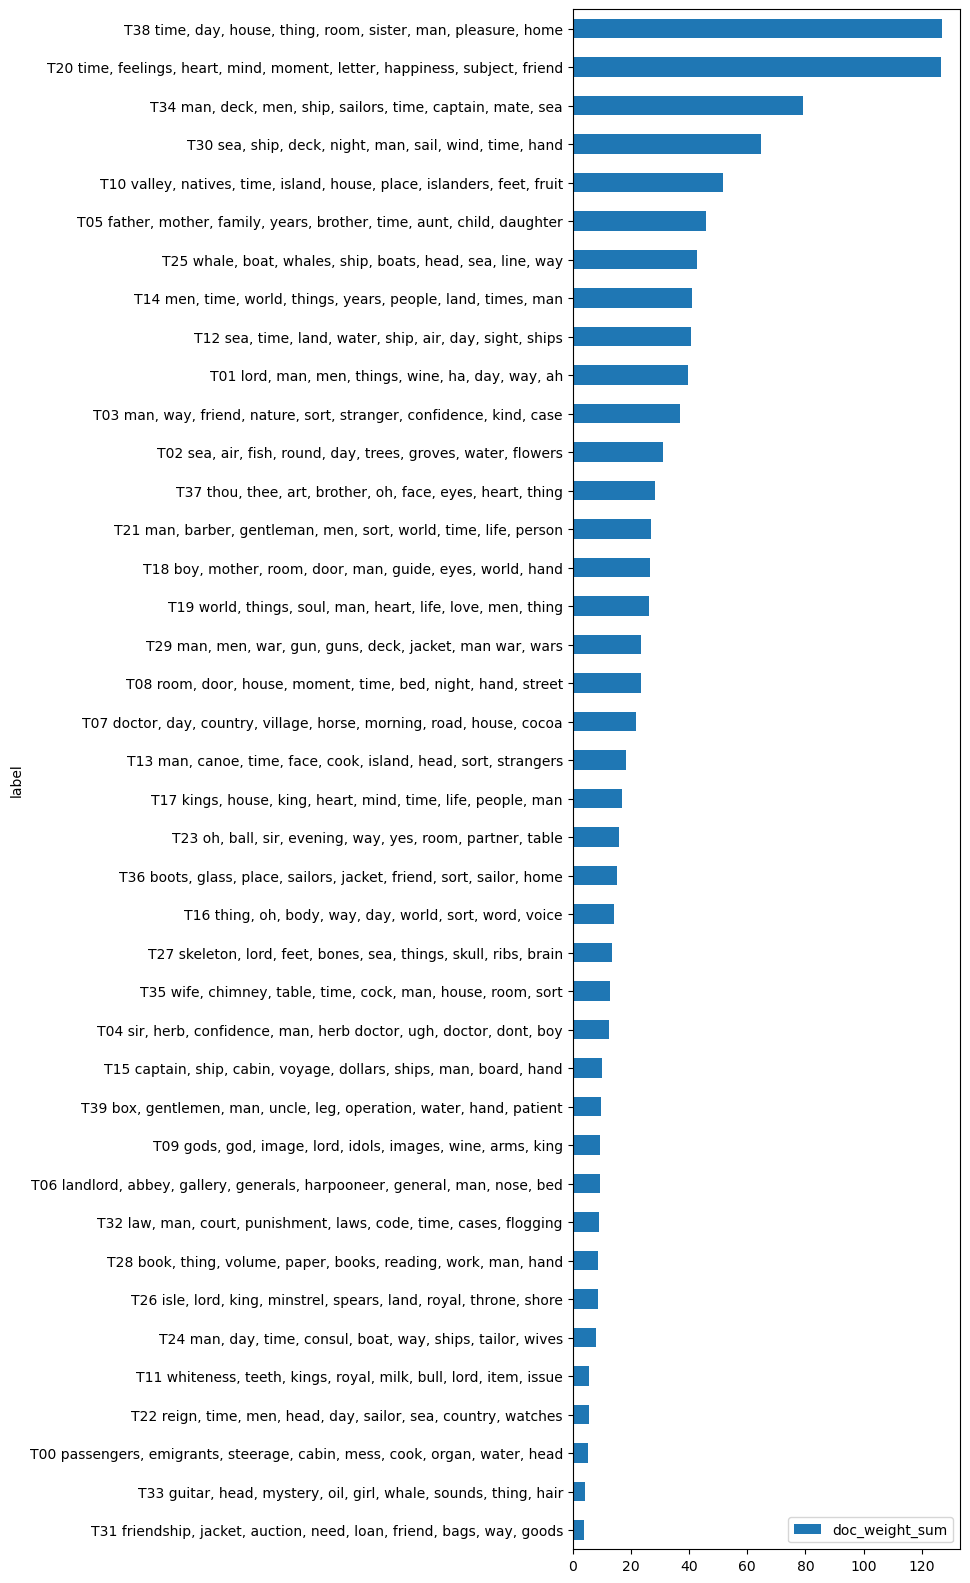

In [99]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5, n_topics/2));

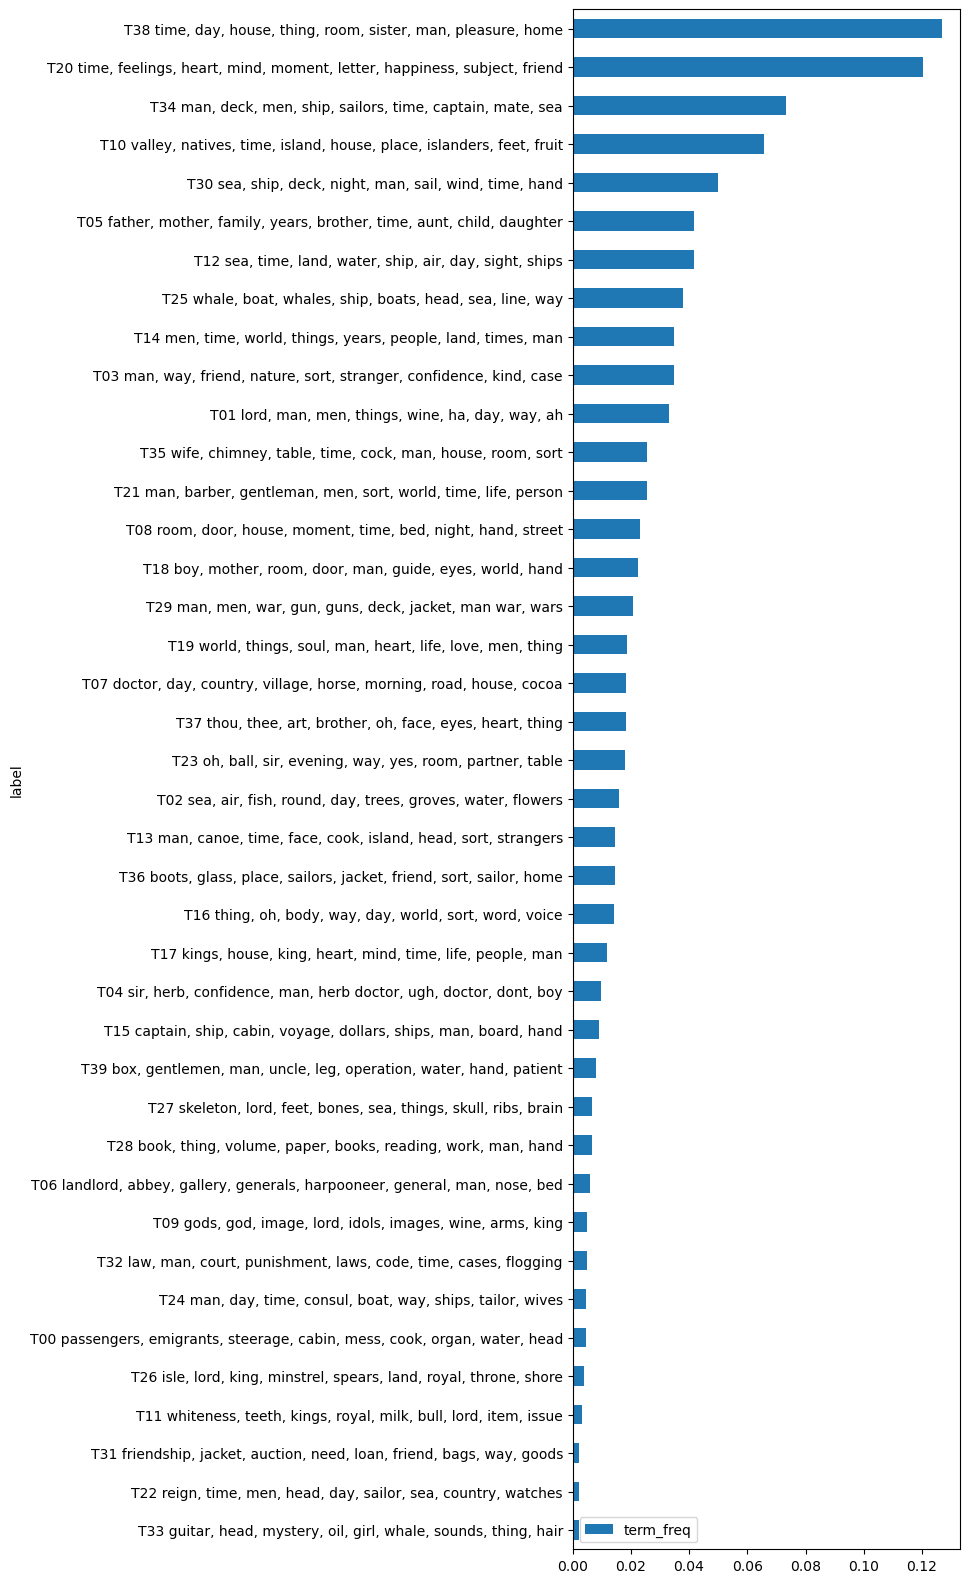

In [100]:
TOPICS.sort_values('term_freq', ascending=True).plot.barh(y='term_freq', x='label', figsize=(5,n_topics/2));

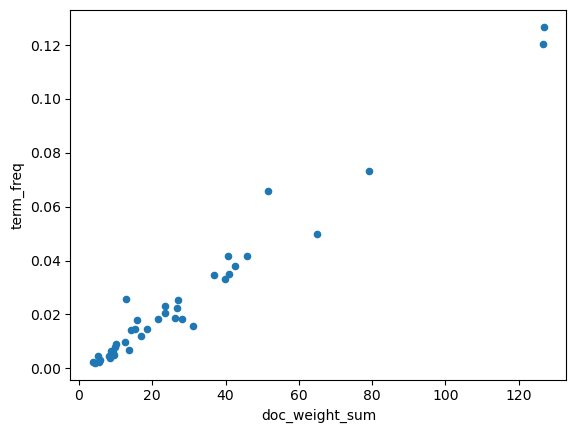

In [101]:
TOPICS.plot.scatter('doc_weight_sum', 'term_freq');

# Explore Topics by Author

Use the LIB table to get author info.

In [102]:
LIB = pd.read_csv(f'{data_in}/{data_prefix}-LIB_FIXED.csv').set_index('book_id')

Create a short label for each author for display purposes.

In [103]:
LIB['author_key'] = LIB.author.str.split(', ').str[0].str.lower()

Add mean topic weight for each topic by author.

In [104]:
AUTHORS = sorted(LIB.author_key.value_counts().index.to_list())

In [105]:
# THETA.join(LIB, on='book_id')\
#     .groupby('author_key')[TNAMES].mean()\
#     .T

In [106]:
TOPICS[AUTHORS] = THETA.join(LIB, on='book_id').groupby('author_key')[TNAMES].mean().T

In [107]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8,label,doc_weight_sum,term_freq,austen,melville
topic_id,,,,,,,,,,,,,,
T00,passengers,emigrants,steerage,cabin,mess,cook,organ,water,head,"T00 passengers, emigrants, steerage, cabin, me...",5.170136,0.004492,0.000397,0.006393
T01,lord,man,men,things,wine,ha,day,way,ah,"T01 lord, man, men, things, wine, ha, day, way...",39.761247,0.033112,0.001860,0.049670
T02,sea,air,fish,round,day,trees,groves,water,flowers,"T02 sea, air, fish, round, day, trees, groves,...",31.197993,0.015807,0.000782,0.039260
T03,man,way,friend,nature,sort,stranger,confidence,kind,case,"T03 man, way, friend, nature, sort, stranger, ...",36.842409,0.034729,0.003035,0.045468
T04,sir,herb,confidence,man,herb doctor,ugh,doctor,dont,boy,"T04 sir, herb, confidence, man, herb doctor, u...",12.614978,0.009658,0.001432,0.015402
T05,father,mother,family,years,brother,time,aunt,child,daughter,"T05 father, mother, family, years, brother, ti...",45.796196,0.041761,0.112273,0.010529
T06,landlord,abbey,gallery,generals,harpooneer,general,man,nose,bed,"T06 landlord, abbey, gallery, generals, harpoo...",9.341365,0.006017,0.005437,0.009550
T07,doctor,day,country,village,horse,morning,road,house,cocoa,"T07 doctor, day, country, village, horse, morn...",21.689520,0.018303,0.011965,0.022454
T08,room,door,house,moment,time,bed,night,hand,street,"T08 room, door, house, moment, time, bed, nigh...",23.370074,0.022998,0.028895,0.017410


View by topic order.

In [128]:
TOPICS[AUTHORS + ['label']].style.background_gradient(cmap=colors, axis=None)

term_str,austen,melville,label
topic_id,,,
T00,0.000397,0.006393,"T00 passengers, emigrants, steerage, cabin, mess, cook, organ, water, head"
T01,0.001860,0.049670,"T01 lord, man, men, things, wine, ha, day, way, ah"
T02,0.000782,0.039260,"T02 sea, air, fish, round, day, trees, groves, water, flowers"
T03,0.003035,0.045468,"T03 man, way, friend, nature, sort, stranger, confidence, kind, case"
T04,0.001432,0.015402,"T04 sir, herb, confidence, man, herb doctor, ugh, doctor, dont, boy"
T05,0.112273,0.010529,"T05 father, mother, family, years, brother, time, aunt, child, daughter"
T06,0.005437,0.009550,"T06 landlord, abbey, gallery, generals, harpooneer, general, man, nose, bed"
T07,0.011965,0.022454,"T07 doctor, day, country, village, horse, morning, road, house, cocoa"
T08,0.028895,0.017410,"T08 room, door, house, moment, time, bed, night, hand, street"


In [130]:
TOPICS[AUTHORS + ['label']].sort_values('austen', ascending=False).style.background_gradient(cmap=colors, axis=None)

term_str,austen,melville,label
topic_id,,,
T38,0.357309,0.009528,"T38 time, day, house, thing, room, sister, man, pleasure, home"
T20,0.343993,0.014870,"T20 time, feelings, heart, mind, moment, letter, happiness, subject, friend"
T05,0.112273,0.010529,"T05 father, mother, family, years, brother, time, aunt, child, daughter"
T21,0.038971,0.017793,"T21 man, barber, gentleman, men, sort, world, time, life, person"
T23,0.033419,0.005925,"T23 oh, ball, sir, evening, way, yes, room, partner, table"
T08,0.028895,0.017410,"T08 room, door, house, moment, time, bed, night, hand, street"
T16,0.023458,0.008148,"T16 thing, oh, body, way, day, world, sort, word, voice"
T07,0.011965,0.022454,"T07 doctor, day, country, village, horse, morning, road, house, cocoa"
T28,0.005876,0.008758,"T28 book, thing, volume, paper, books, reading, work, man, hand"


In [129]:
TOPICS[AUTHORS + ['label']].sort_values('melville', ascending=False).style.background_gradient(cmap=colors, axis=None)

term_str,austen,melville,label
topic_id,,,
T34,0.002328,0.099593,"T34 man, deck, men, ship, sailors, time, captain, mate, sea"
T30,0.000556,0.082039,"T30 sea, ship, deck, night, man, sail, wind, time, hand"
T10,0.001799,0.064646,"T10 valley, natives, time, island, house, place, islanders, feet, fruit"
T25,0.000326,0.053971,"T25 whale, boat, whales, ship, boats, head, sea, line, way"
T14,0.001014,0.051701,"T14 men, time, world, things, years, people, land, times, man"
T12,0.000964,0.051337,"T12 sea, time, land, water, ship, air, day, sight, ships"
T01,0.001860,0.049670,"T01 lord, man, men, things, wine, ha, day, way, ah"
T03,0.003035,0.045468,"T03 man, way, friend, nature, sort, stranger, confidence, kind, case"
T02,0.000782,0.039260,"T02 sea, air, fish, round, day, trees, groves, water, flowers"


Sort by Melville's top topics.

Sort by Austen's top topics.

## Add Authors to Topics

Associate authors with topics, i.e. assign author for whom topic has highest mean value.

In [111]:
TOPICS['author'] = TOPICS[AUTHORS].idxmax(1)

In [112]:
TOPICS.iloc[:,n_top_terms:].sort_values(['author','doc_weight_sum'], ascending=[True,False]).style.background_gradient(cmap=colors)

term_str,label,doc_weight_sum,term_freq,austen,melville,author
topic_id,,,,,,
T38,"T38 time, day, house, thing, room, sister, man, pleasure, home",126.849768,0.126781,0.357309,0.009528,austen
T20,"T20 time, feelings, heart, mind, moment, letter, happiness, subject, friend",126.611068,0.120277,0.343993,0.014870,austen
T05,"T05 father, mother, family, years, brother, time, aunt, child, daughter",45.796196,0.041761,0.112273,0.010529,austen
T21,"T21 man, barber, gentleman, men, sort, world, time, life, person",27.036913,0.025558,0.038971,0.017793,austen
T08,"T08 room, door, house, moment, time, bed, night, hand, street",23.370074,0.022998,0.028895,0.017410,austen
T23,"T23 oh, ball, sir, evening, way, yes, room, partner, table",15.830761,0.018105,0.033419,0.005925,austen
T16,"T16 thing, oh, body, way, day, world, sort, word, voice",14.255702,0.014171,0.023458,0.008148,austen
T34,"T34 man, deck, men, ship, sailors, time, captain, mate, sea",79.256877,0.073374,0.002328,0.099593,melville
T30,"T30 sea, ship, deck, night, man, sail, wind, time, hand",64.832434,0.049921,0.000556,0.082039,melville


## Topics in Author Space

See how topics are associated with author dimensions.

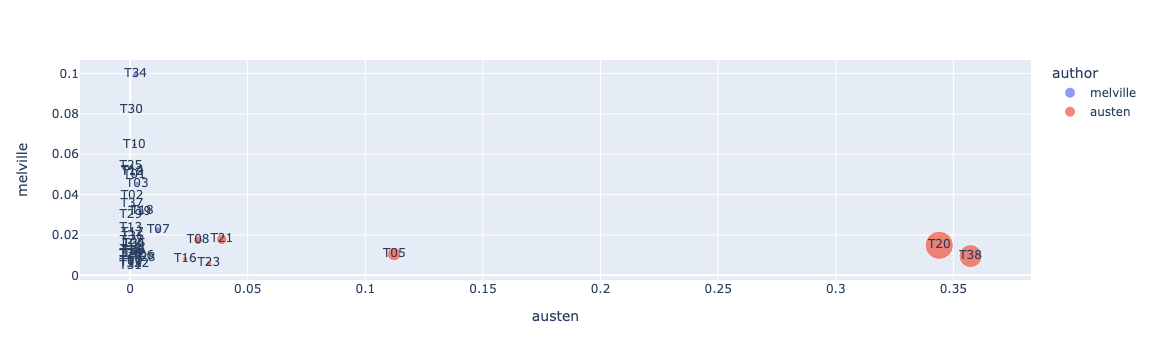

In [113]:
px.scatter(TOPICS.reset_index(), 'austen', 'melville', 
           hover_name='label', text='topic_id', 
           size=(TOPICS.austen * TOPICS.melville),
           color='author',
           width=1000, height=350)

# Save Model

In [114]:
DOCS.to_csv(f'{data_out}/{data_prefix}-LDA_DOCS-chaps.csv')
TOPICS.to_csv(f'{data_out}/{data_prefix}-LDA_TOPICS-{n_topics}.csv')
THETA.to_csv(f'{data_out}/{data_prefix}-LDA_THETA-{n_topics}.csv')
PHI.to_csv(f'{data_out}/{data_prefix}-LDA_PHI-{n_topics}.csv')

In [115]:
import pickle

In [119]:
pickle.dump(lda_model, open(f'{data_out}/{data_prefix}-lda_model.pickle', 'wb'))
pickle.dump(lda_engine, open(f'{data_out}/{data_prefix}-lda_engine.pickle', 'wb'))
pickle.dump(count_engine, open(f'{data_out}/{data_prefix}-count_engine.pickle', 'wb'))
pickle.dump(count_model, open(f'{data_out}/{data_prefix}-count_model.pickle', 'wb'))